# Gaussian Process Classification

Code implementing GP classification via the Laplace approximation, based on chapter 6 of [Bishop's PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/). 

In [71]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt


# Defining epsilon for limits
eps = 1e-6
    
# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 3.0
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'

# Fix np.random seed for replicability
np.random.seed(0)

## Choice of kernel

In class, we discussed about the different kernels that we can use to define a GP. A nice example kernel is given in  Eq. 6.63 in Bishop
$$
\begin{align}
    k_{\theta}(x, y) = \theta_0 \exp\left( -\frac{\theta_1}{2} \| x - y \|^2 \right) + \theta_2 + \theta_3 x^T y
\end{align}
$$
with non-negative hyper parameters $\theta_0, \theta_1, \theta_2, \theta_3$
(At least one of $\theta_0, \theta_2, \theta_3$ has to be positive for $K$ to be positive definite).
Below we will implement this kernel.

In [4]:
class MyKernel:
    
    def __init__(self, theta, bounds=None):
        self.theta = theta
        self.bounds = bounds
        
    def __call__(self, X, Y, eval_gradient=False):
        '''
        Compute kernel matrix for two data vectors
        
        Parameters
        ----------
        X, Y : 2-D numpy array
            Input points. X[n, i] (resp. Y[n, i]) = i-th element of n-th point in X (resp Y).
        eval_gradient : bool
            If True, return gradient of kernel matrix w.r.t. to hyperparams
            
        Returns
        ----------
        K : 2-D numpy array, shape = (len(X), len(Y))
            Kernel matrix K[i, j]= k(X[i], Y[j])
        gradK : 3-D numpy array, shape = (len(self.theta), len(X), len(Y)), optional
            Gradient of kernel matrix. gradK[i, m, n] = derivative of K[m, n] w.r.t. self.theta[i]
            Returned only if return_std is True.
        '''
            
        tmp = np.reshape(np.sum(X**2,axis=1), (len(X), 1)) + np.sum(Y**2, axis=1)  -2 * (X @ Y.T)
        K = self.theta[0]*np.exp(-self.theta[1]/2*tmp) + self.theta[2] + self.theta[3]*(X @ Y.T)
        
        if not(eval_gradient):
            return K
        else:
            gradK = np.zeros((len(self.theta), len(X), len(Y)))
            gradK[0] = np.exp(-self.theta[1]/2*tmp)
            gradK[1] = -self.theta[0]/2*tmp*np.exp(-self.theta[1]/2*tmp)
            gradK[2] = np.ones((len(X), len(Y)))
            gradK[3] = X @ Y.T
            return K, gradK

In [90]:
from scipy.special import expit as sigmoid

def W_mat(a):
    """Helper to compute matrix W"""
    r = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(r.ravel())

def posterior_mode(X,t,K,max_iter=100, tol=1e-9):
    """
    Computes the mode of posterior p(a|t) (via iterated Newton-Raphson)
    Parameters
    ----------
    X : 2-D numpy array
        Array representing training input data, with X[n, i] being the i-th element of n-th point in X.
    t : 1-D numpy array
        Array representing training label data.
    optimize_hparams : bool
        If True, optimization of kernel hyperparameters is performed.
    """
    a_h = np.zeros(np.shape(t))
    I = np.eye(X.shape[0])
    for i in range(max_iter):
      W = W_mat(a_h)
      Q_inv = np.linalg.pinv(I + W @ K)
      a_h_new = (K @ Q_inv).dot(t - sigmoid(a_h) + W.dot(a_h))
      a_h_diff = np.abs(a_h_new - a_h)
      a_h = a_h_new
      if not np.any(a_h_diff > tol):
        break
    return a_h
        
class GPClassification:
    
    def __init__(self, kernel):
        self.kernel = kernel
            
    def fit(self, X, t, optimize_hparams=False):
        '''
        Parameters
        ----------
        X : 2-D numpy array
            Array representing training input data, with X[n, i] being the i-th element of n-th point in X.
        t : 1-D numpy array
            Array representing training label data.
        optimize_hparams : bool
            If True, optimization of kernel hyperparameters is performed.
        '''
        self.X_train = X
        self.t_train = t
        if optimize_hparams:
            bounds_full = self.kernel.bounds
            result = minimize(x0=self.kernel.theta,
                              fun=lambda x : neglog_evidence(theta=x, kernel=self.kernel, X=self.X_train, t=self.t_train, return_grad=True), 
                              jac=True,
                              bounds=bounds_full,
                              method = 'TNC',
                              tol=eps)
            print(result.message)
            self.kernel.theta = result.x
        
    def predict_y(self, X_test,nu = 1e-5):
        '''       
        Parameters
        ----------
        X_test : 2-D numpy array
            Array representing test input data, with X_test[n, i] being the i-th element of n-th point in X.
        
        Returns
        ----------
        mean : 1-D numpy array
            Array representing predictive mean.
        '''
        K = self.kernel(self.X_train, self.X_train) + nu * np.eye(self.X_train.shape[0])
        k = self.kernel(self.X_train,X_test)
        c = self.kernel(X_test,X_test)

        y_lap = posterior_mode(self.X_train,self.t_train,K)

        pred_mean = k.T @ (self.t_train - sigmoid(y_lap))

        Winv = np.linalg.pinv(W_mat(y_lap))
        pred_cov = c - k.T @ np.linalg.pinv(K + Winv ) @ k

        return pred_mean, pred_cov


    def predict_prob(self, X_test):
        K = self.kernel(self.X_train, self.X_train)
        y_lap = posterior_mode(self.X_train,self.t_train,K)

        k = self.kernel(self.X_train,X_test)
        pred_mean = k.T @ (self.t_train - sigmoid(y_lap))

        Winv = np.linalg.pinv(W_mat(y_lap))

        # computing only the diagonal elements of Ker(x_test,x_test) for scalability
        c = np.array([kernel(np.asarray([x]),np.asarray([x])) for x in X_test]).ravel()
        
        pred_var = c - np.diagonal(k.T @ np.linalg.pinv(K + Winv ) @ k)
        kappa = 1.0 / np.sqrt(1.0 + np.pi * pred_var / 8)

        return sigmoid(kappa * pred_mean)         


def plot_probs(pred_probs, Xtest, ax=None):
    '''       
      Parameters
      ----------
      pred_probs : 1-D numpy array
            Array containing the predicted probabilities
      ax : Axes for plotting
    '''
    if ax is None:
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(111)

    ax.hlines(0.5,np.min(Xtest),np.max(Xtest),'b')
    ax.plot(X, t,'og',markersize=10,label='training data')
    ax.plot(Xtest, pred_probs, label='predicted probs')
    ax.plot(Xtest, sigmoid(truef(Xtest)), ':r', label='ground truth probs')

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.legend()

def plot_GP(pred_mean,pred_cov,Xtest,ax=None):
    '''       
      Parameters
      ----------
      pred_mean : 1-D numpy array
            Array containing the predicted mean
      pred_cov : 2-D numpy array
            Array containing the predicted covariance
      ax : Axes for plotting
    '''
    if ax is None:
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(111)
    
    ax.plot(Xtest, pred_mean, label='predictive mean')
    ax.plot(Xtest, truef(Xtest), ':r', label='ground truth')
    pred_stddev = np.sqrt(np.diagonal(pred_cov))
    upper_cb = pred_mean + 2*pred_stddev
    lower_cb = pred_mean - 2*pred_stddev
    Xtest = Xtest.ravel()
    ax.fill_between(Xtest, upper_cb, lower_cb, alpha=0.2)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.legend()

Empirical Bayes (and any general model comparison) also needs the marginal likelihood. Indeed, one way to think about the `cost' of a given vector of hyperparameters is in terms of the *negative log of the marginal likelihood*. Given dataset $D=\{(x_i,t_i)\}_{i\in[N]}$, and with $y_{L}$ denoting the posterior mode, under the Laplace approximation we have (all logarithms in base $e$):
$$
\begin{align}
-\log p(y|D) = \frac{1}{2}\log|I + K_DW|+ \frac{1}{2}y_L^T(K_D)^{-1}y_L - y_L^Tt + \sum_{i=1}^N\log\Big[1+e^{t[i]y_L[i]}\Big]
\end{align}
$$



In [104]:
def neglog_evidence(theta, kernel, X, t, return_grad = False):
    '''
   'cost' of hyperparameters is the (negative of the log of) the marginal likelihood
    
    Parameters
    ----------
    theta : 1-D numpy array
        kernel parameters
    kernel : kernel object
        the kernel function
    X : 2-D numpy array
        input data, X[n, i] = i-th element of n-th point in X.
    t : 1-D numpy array
        label data
        
    Returns
    ----------
    val : float
        value of the cost function
    '''

    kernel.theta = theta
    K, gradK = kernel(X, X, eval_gradient=True)
    Kinv = np.linalg.pinv(K)
    y_lap = posterior_mode(X, t, K)
    W = W_mat(y_lap)
    C = np.eye(len(y_lap)) + K @ W

    val = 0.5*(y_lap.T @ Kinv @ y_lap + np.linalg.slogdet(C)[1]) - t @ y_lap + np.sum(np.log(1.0+np.exp(y_lap)))
    
    if not(return_grad):
        return val
    else:
        grad = np.zeros(len(theta))
        Cinv = np.linalg.pinv(C)
        sig_lap = sigmoid(y_lap)
        for cnt in range(len(theta)):
            # Using the formula for the gradient from Bishop 6.4.6
            z = Cinv @ gradK[cnt] @ (t - sig_lap)
            grad[cnt] = 0.5 * np.trace(Cinv @ W @ gradK[cnt]) - 0.5 * y_lap @ Kinv @ gradK[cnt] @ Kinv @ y_lap \
                        + 0.5*np.sum(np.diagonal(Cinv @ K) * sig_lap * (1.0-sig_lap) * (1.0-2.0*sig_lap) * z)
        return val, grad

## GP regression with fixed hyperparameters 

Generating the ground truth and data

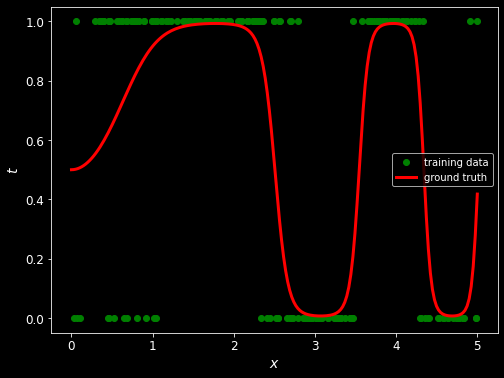

In [42]:
def truef(x):
    return 5*np.sin(x**2 *0.5) 
    #return 5*(x-2)**2 - 5


x_min = 0
x_max = 5


N = 200

X = np.random.uniform(x_min,x_max, N)

t = np.random.binomial(1,sigmoid(truef(X)))


# Generate grid for plotting
Xcont = np.linspace(x_min,x_max,200) 

plt.figure(figsize=(8,6))
plt.plot(X, t,'og', label='training data')
plt.plot(Xcont, sigmoid(truef(Xcont)), '-r',label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

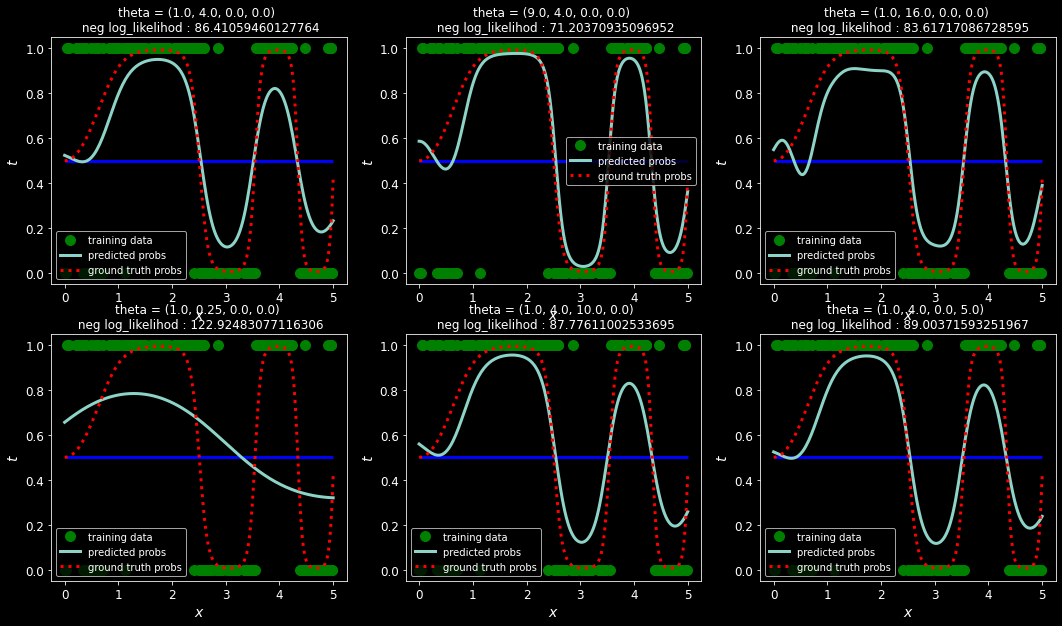

In [36]:
Thts = np.array([[1.0, 4.0, 0.0, 0.0],
                 [9.0, 4.0, 0.0, 0.0],
                 [1.0, 16.0, 0.0,0.0],
                 [1.0,0.25, 0.0, 0.0],
                 [1.0, 4.0, 10.0, 0.0],
                 [1.0, 4.0, 0.0, 5.0]
                ])

beta = 3.0

kernel = MyKernel(theta = np.array([0.0, 0.0, 0.0, 0.0]), bounds=[[0.0, None],[0.0, None],[0.0, None],[0.0, None]])
gpr = GPClassification(kernel=kernel)

fig = plt.figure(figsize=(18,10))
cnt = 0
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel.theta = theta
    gpr.fit(X, t)
    pred_probs = gpr.predict_prob(Xtest)
    ax = fig.add_subplot(2, 3, cnt+1)
    plot_probs(pred_probs,Xtest,ax=ax)
    ax.set_title(f"theta = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]}) \n neg log_likelihod : {neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")
    cnt += 1
plt.show()

We can also view the GP in the latent variable space

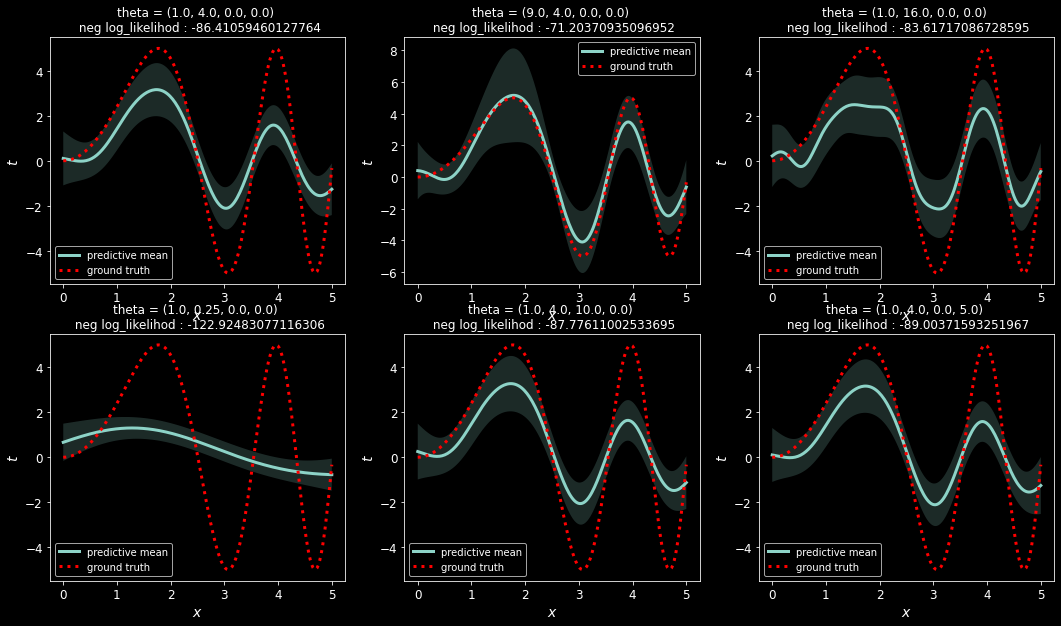

In [37]:
fig = plt.figure(figsize=(18,10))
cnt = 0
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel.theta = theta
    gpr.fit(X, t)
    pred_mean,pred_cov = gpr.predict_y(Xtest)
    ax = fig.add_subplot(2, 3, cnt+1)
    plot_GP(pred_mean.T,pred_cov,Xtest,ax=ax)
    ax.set_title(f"theta = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]}) \n neg log_likelihod : {-neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")
    cnt += 1
plt.show()

## GP classification with tuned hyperparameters

As in regression, we can also use the evidence approximation for GP regression by choosing hyperparameters $\theta_i$ to maximize the evidence function for the data $p(D|\{\theta_i\})$ (see Bishop, Section 6.4.3). We use the minimize function from scipy.optimize (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to minimize the evidence.

Converged (|x_n-x_(n-1)| ~= 0)
theta=[21.78424166  5.71136516  0.42756402  4.85667077]
log_likelihod : -75.58290738961563


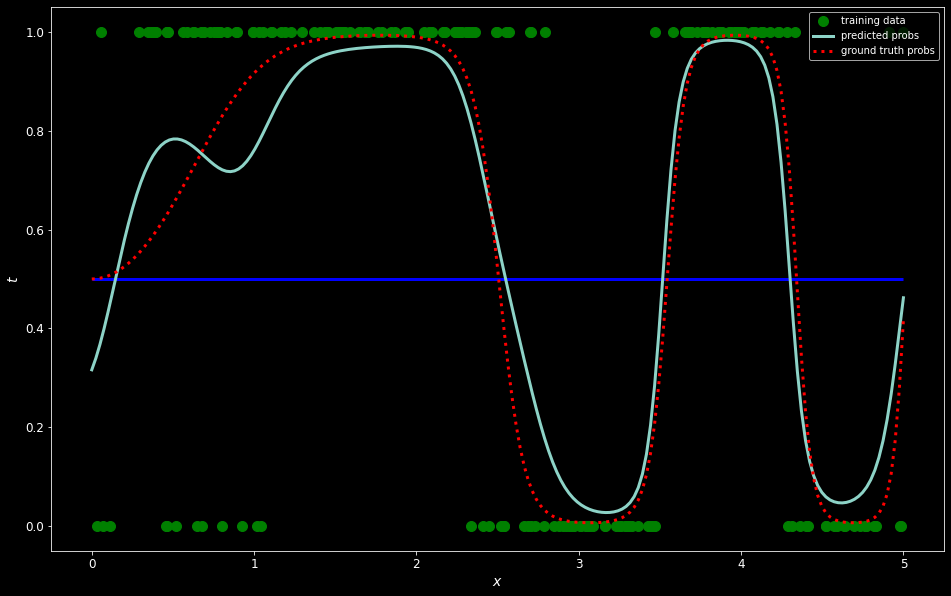

In [56]:
kernel = MyKernel(theta = np.array([4.0, 10.0, 0.01, 0.01]), bounds=[[0.0, None],[0.0, None],[0.0, None],[0.0, None]])
gpr = GPClassification(kernel=kernel)
gpr.fit(X, t, optimize_hparams=True)
pred_probs = gpr.predict_prob(Xtest)
print(f"theta={kernel.theta}")
print(f"log_likelihod : {-neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")
plot_probs(pred_probs, Xtest)

<Figure size 1296x720 with 0 Axes>

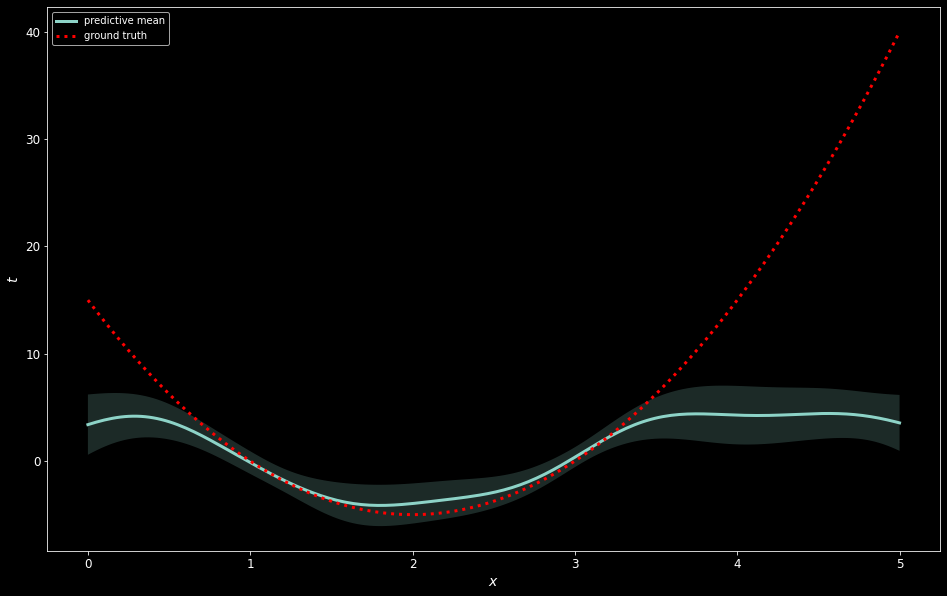

In [16]:
fig = plt.figure(figsize=(18,10))
theta = gpr.kernel.theta
pred_mean,pred_cov = gpr.predict_y(Xtest)
plot_GP(pred_mean,pred_cov,Xtest)

## GP regression in scikit-learn

Finally, we show how to perform the above using scikit-learn (see https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes for details)

In [17]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel 

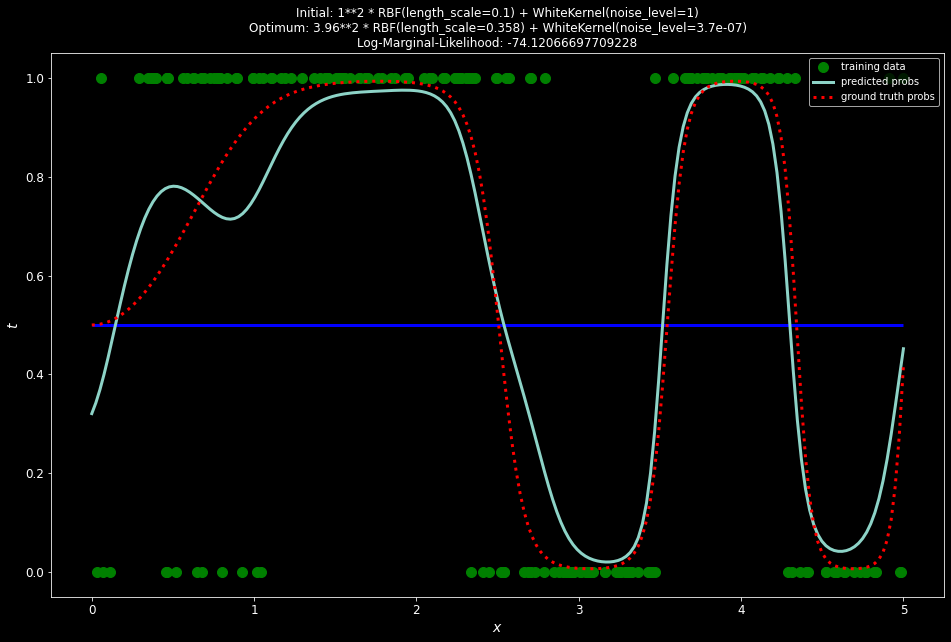

In [48]:
kernel = ConstantKernel(1.0) * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 3e+1))
gpc = GaussianProcessClassifier(kernel=kernel)

# fitting 
gpc.fit(X, t)

# prediction
pred_probs = gpc.predict_proba(Xtest)[:,1]

# plotting
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1)
plot_probs(pred_probs,Xtest,ax=ax)
ax.set_title(f"Initial: {kernel}\n\
Optimum: {gpc.kernel_}\n\
Log-Marginal-Likelihood: {gpc.log_marginal_likelihood(gpc.kernel_.theta)}")
plt.show()

## A 2-d example

We first define some additional plotting functions

In [66]:
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D

def plot_data_2D(X, t):
    class_1 = np.ravel(t == 1)
    class_0 = np.ravel(t == 0)
    plt.scatter(X[class_1, 0], X[class_1, 1], label='Class 1', marker='x', c='red')
    plt.scatter(X[class_0, 0], X[class_0, 1], label='Class 0', marker='x', c='cyan')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

def plot_classifier_2D(grid_x, grid_y, grid_z, decision_boundary=0.5):
    plt.contourf(grid_x, grid_y, grid_z, cmap='cool', alpha=0.3, levels=np.linspace(0, 1, 11))
    plt.colorbar(format='%.2f')
    levels = [decision_boundary]
    cs = plt.contour(grid_x, grid_y, grid_z, levels=levels, colors='yellow', linestyles='dashed', linewidths=2)
    plt.clabel(cs, fontsize=20)

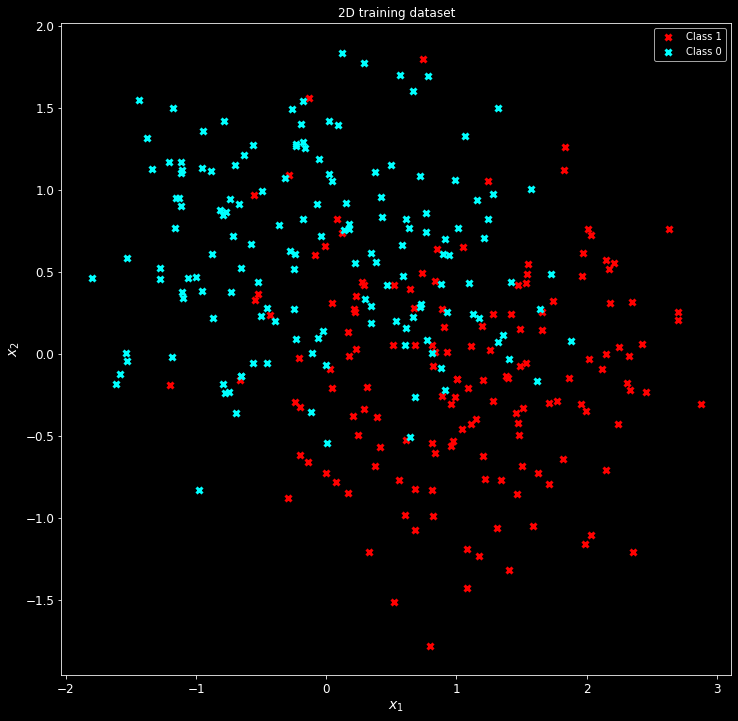

In [85]:
from sklearn.datasets import make_moons

num_samples = 300
X, t = make_moons(num_samples, noise=0.5, random_state=1)
t = t.ravel()

x_min = 1.1*np.min(X[:,0])
x_max = 1.1*np.max(X[:,0])
y_min = 1.1*np.min(X[:,1]) 
y_max = 1.1*np.max(X[:,1])

plt.figure(figsize=(12,12))
plot_data_2D(X, t)
plt.title('2D training dataset')
plt.legend();

We need to define a 2-d grid for plotting

In [61]:
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
grid = np.stack([grid_x, grid_y], axis=-1)
grid = grid.reshape(-1, 2)

In [76]:
class RBFkernel:
    
    def __init__(self, theta, bounds=None):
        self.theta = theta
        self.bounds = bounds
        
    def __call__(self, X, Y, eval_gradient=False):
        '''
        Compute kernel matrix for two data vectors
        
        Parameters
        ----------
        X, Y : 2-D numpy array
            Input points. X[n, i] (resp. Y[n, i]) = i-th element of n-th point in X (resp Y).
        eval_gradient : bool
            If True, return gradient of kernel matrix w.r.t. to hyperparams
            
        Returns
        ----------
        K : 2-D numpy array, shape = (len(X), len(Y))
            Kernel matrix K[i, j]= k(X[i], Y[j])
        gradK : 3-D numpy array, shape = (len(self.theta), len(X), len(Y)), optional
            Gradient of kernel matrix. gradK[i, m, n] = derivative of K[m, n] w.r.t. self.theta[i]
            Returned only if return_std is True.
        '''
            
        tmp = np.reshape(np.sum(X**2,axis=1), (len(X), 1)) + np.sum(Y**2, axis=1)  -2 * (X @ Y.T)
        K = self.theta[0]*np.exp(-tmp*self.theta[1]/2.0) + self.theta[2]
        
        if not(eval_gradient):
            return K
        else:
            gradK = np.zeros((len(self.theta), len(X), len(Y)))
            gradK[0] = np.exp(-tmp*self.theta[1]/2.0)
            gradK[1] = -(tmp*self.theta[0]/2.0)*np.exp(-tmp*self.theta[1]/2.0)
            gradK[2] = np.ones((len(X), len(Y)))
            return K, gradK

As before, we can again first try with fixed hyperparameters

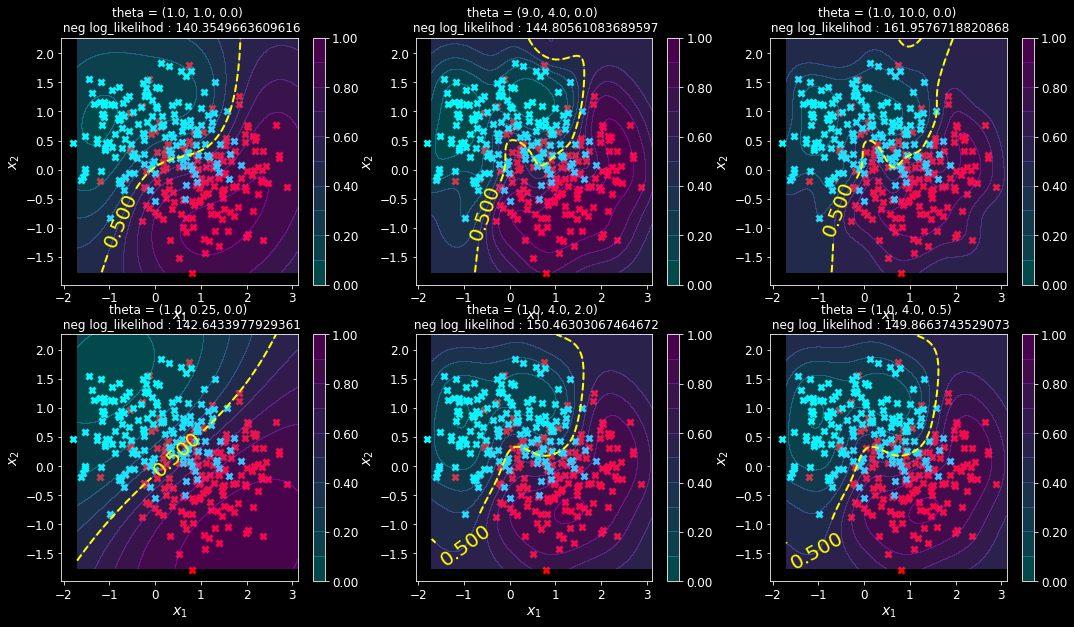

In [87]:
Thts = np.array([[1.0, 1.0, 0.0],
                 [9.0, 4.0, 0.0],
                 [1.0, 10.0, 0.0],
                 [1.0,0.25, 0.0],
                 [1.0, 4.0, 2.0],
                 [1.0, 4.0, 0.5]
                ])

kernel = RBFkernel(theta = np.array([0.0, 0.0, 0.0]), bounds=[[0.0, None],[0.0, None],[0.0, None]])
gpr = GPClassification(kernel=kernel)

fig = plt.figure(figsize=(18,10))
cnt = 0
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel.theta = theta
    gpr.fit(X, t)
    pred_probs = gpr.predict_prob(grid).reshape(*grid_x.shape)
    ax = fig.add_subplot(2, 3, cnt+1)
    plot_data_2D(X, t)
    plot_classifier_2D(grid_x, grid_y, pred_probs, decision_boundary = 0.5)
    ax.set_title(f"theta = ({theta[0]}, {theta[1]}, {theta[2]}) \n neg log_likelihod : {neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")
    cnt += 1
plt.show()

In [93]:
kernel = RBFkernel(theta = np.array([1.0, 1.0, 0.01]), bounds=[[0.0, None],[0.0, None],[0.0, None]])
gpr = GPClassification(kernel=kernel)
gpr.fit(X, t, optimize_hparams=True)
print(f"Final kernel hyperparams={kernel.theta}\n\
#Log-Marginal-Likelihood: {-neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")

Max. number of function evaluations reached
Final kernel hyperparams=[21.91208149  0.79186294  0.        ]
#Log-Marginal-Likelihood: -134.08381893739326


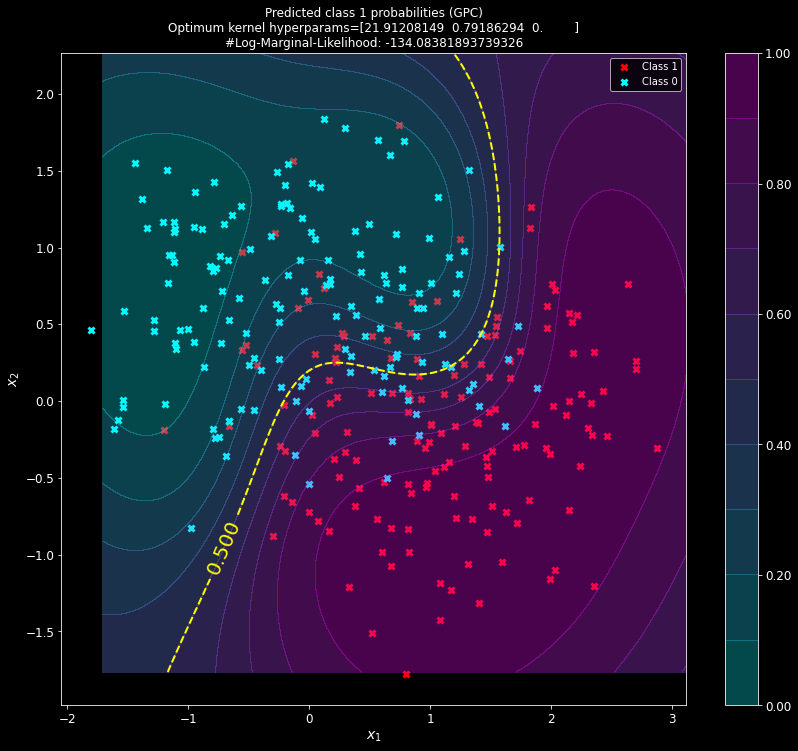

In [95]:
pred_probs = gpr.predict_prob(grid).reshape(*grid_x.shape)

plt.figure(figsize=(14, 12))
plot_data_2D(X, t)
plot_classifier_2D(grid_x, grid_y, pred_probs, decision_boundary = 0.5)

plt.title('Predicted class 1 probabilities (GPC)\n'+f"Optimum kernel hyperparams={kernel.theta}\n\
#Log-Marginal-Likelihood: {-neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")

plt.legend();

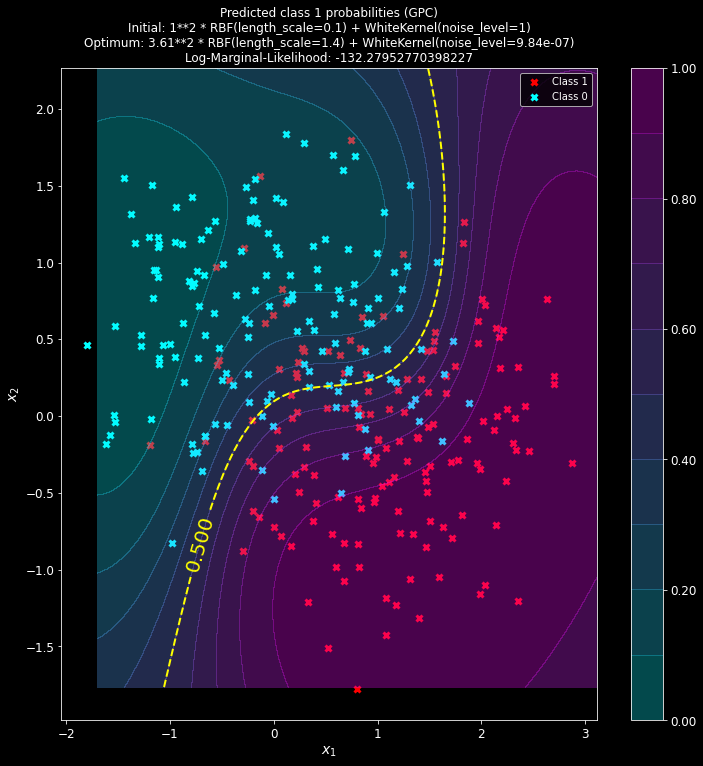

In [88]:
kernel = ConstantKernel(1.0) * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 3e+1))
gpc = GaussianProcessClassifier(kernel=kernel)

gpc.fit(X, t.ravel())

pt_test_gpc = gpc.predict_proba(grid)[:, 1].reshape(*grid_x.shape)

plt.figure(figsize=(12,12))
plot_data_2D(X, t)
plot_classifier_2D(grid_x, grid_y, pt_test_gpc, decision_boundary = 0.5)

plt.title('Predicted class 1 probabilities (GPC)\n'+f"Initial: {kernel}\n\
Optimum: {gpc.kernel_}\n\
Log-Marginal-Likelihood: {gpc.log_marginal_likelihood(gpc.kernel_.theta)}")

plt.legend();

Another example using the make_circles dataset from scikit_learn

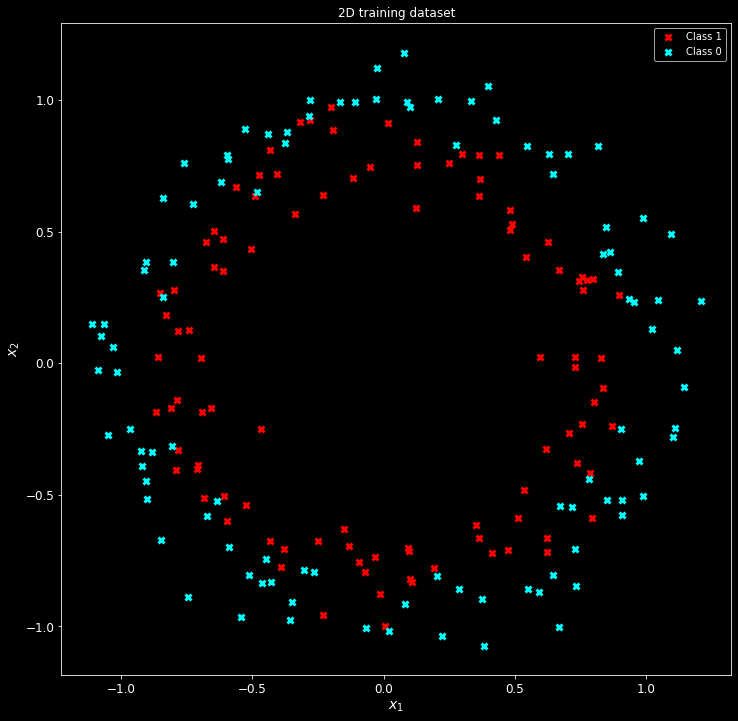

In [98]:
from sklearn.datasets import make_circles

num_samples = 200
X, t = make_circles(num_samples, noise=0.1, random_state=1)
t = t.ravel()

x_min = 1.1*np.min(X[:,0])
x_max = 1.1*np.max(X[:,0])
y_min = 1.1*np.min(X[:,1]) 
y_max = 1.1*np.max(X[:,1])

plt.figure(figsize=(12,12))
plot_data_2D(X, t)
plt.title('2D training dataset')
plt.legend();

In [100]:
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
grid = np.stack([grid_x, grid_y], axis=-1)
grid = grid.reshape(-1, 2)

Max. number of function evaluations reached


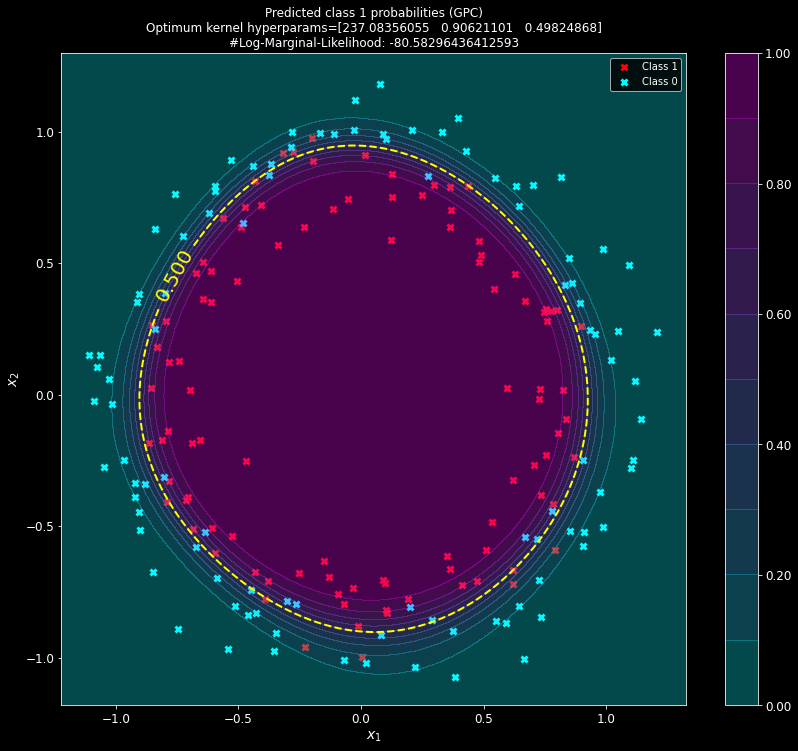

In [103]:
kernel = RBFkernel(theta = np.array([20.0, 1.0, 0.00]), bounds=[[0.0, None],[0.0, None],[0.0, 2.0]])
gpr = GPClassification(kernel=kernel)
gpr.fit(X, t, optimize_hparams=True)

pred_probs = gpr.predict_prob(grid).reshape(*grid_x.shape)

plt.figure(figsize=(14, 12))
plot_data_2D(X, t)
plot_classifier_2D(grid_x, grid_y, pred_probs, decision_boundary = 0.5)

plt.title('Predicted class 1 probabilities (GPC)\n'+f"Optimum kernel hyperparams={kernel.theta}\n\
#Log-Marginal-Likelihood: {-neglog_evidence(theta=gpr.kernel.theta, kernel=gpr.kernel, X=X, t=t)}")

plt.legend();

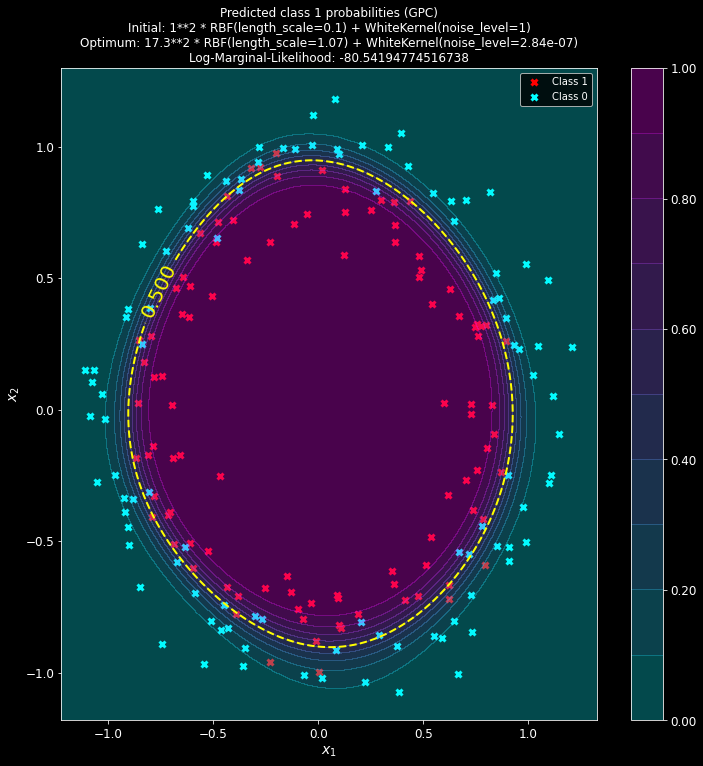

In [102]:
kernel = ConstantKernel(1.0) * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 3e+1))
gpc = GaussianProcessClassifier(kernel=kernel)

gpc.fit(X, t.ravel())

pt_test_gpc = gpc.predict_proba(grid)[:, 1].reshape(*grid_x.shape)

plt.figure(figsize=(12,12))
plot_data_2D(X, t)
plot_classifier_2D(grid_x, grid_y, pt_test_gpc, decision_boundary = 0.5)

plt.title('Predicted class 1 probabilities (GPC)\n'+f"Initial: {kernel}\n\
Optimum: {gpc.kernel_}\n\
Log-Marginal-Likelihood: {gpc.log_marginal_likelihood(gpc.kernel_.theta)}")

plt.legend();